### Import section

In [3]:
from dotenv import load_dotenv
load_dotenv()

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim import Adam

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve

from mongoengine import connect, disconnect
from IPython.display import Image

from settings import DevelopmentConfig

from recommender.models import User, Service
from recommender.engine.preprocessing import SERVICES, USERS, user_and_service_to_tensors, user_and_services_to_tensors
from recommender.engine.datasets.autoencoders import get_autoencoder_dataset_name
from recommender.engine.utils import load_last_dataset, TRAIN, VALID, TEST, load_last_module, save_module
from recommender.engine.training.autoencoders import train_autoencoder, autoencoder_loss_function
from recommender.engine.visualization.autoencoders import get_random_reconstructions, plot_reconstructions
from recommender.engine.models.autoencoders import create_autoencoder_model, create_embedder, SERVICES_AUTOENCODER, USERS_AUTOENCODER

from recommender.engine.agents.pre_agent.models import NEURAL_CF
from recommender.engine.agents.pre_agent.training.neural_collaborative_filtering import train_ncf, evaluate_ncf, accuracy_function
from recommender.engine.agents.pre_agent.models.neural_colaborative_filtering import create_nfc_model, get_preds_for_ds

### connect to database

In [9]:
disconnect()
connect(host=DevelopmentConfig.MONGODB_HOST)

MongoClient(host=['127.0.0.1:27016'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

### set device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### writer
Needed for logging trainings results to the tensorboard (start tensorboard from terminal with `tensorboard --logdir=runs`)

In [6]:
writer = SummaryWriter()

### datasets generation

Use if there are no datasets available in the database

In [7]:
# all_datasets = create_datasets()

# User and Service Auto-Encoders

### Load Service Autoencoder datasets

In [10]:
# SERVICE AUTOENCODER
service_autoencoder_train_ds = load_last_dataset(get_autoencoder_dataset_name(SERVICES, TRAIN))
service_autoencoder_valid_ds = load_last_dataset(get_autoencoder_dataset_name(SERVICES, VALID))
service_autoencoder_test_ds = load_last_dataset(get_autoencoder_dataset_name(SERVICES, TEST))

SERVICE_AE_BATCH_SIZE = 128

service_autoencoder_train_ds_dl = DataLoader(service_autoencoder_train_ds, batch_size=SERVICE_AE_BATCH_SIZE,
                                             shuffle=True)
service_autoencoder_valid_ds_dl = DataLoader(service_autoencoder_valid_ds, batch_size=SERVICE_AE_BATCH_SIZE,
                                             shuffle=True)
service_autoencoder_test_ds_dl = DataLoader(service_autoencoder_test_ds, batch_size=SERVICE_AE_BATCH_SIZE,
                                            shuffle=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

### Create and train Service  Autoencoder

In [7]:
SERVICE_FEATURES_DIM = len(Service.objects[0].tensor)
SERVICE_EMBEDDING_DIM = 64

service_autoencoder_model = create_autoencoder_model(
    SERVICES,
    features_dim=SERVICE_FEATURES_DIM,
    embedding_dim=SERVICE_EMBEDDING_DIM,
    writer=writer,
    train_ds_dl=service_autoencoder_train_ds_dl,
    device=device
)

LR = 0.01
optimizer = Adam(service_autoencoder_model.parameters(), lr=LR)

EPOCHS = 2000

trained_service_autoencoder_model = train_autoencoder(
    model=service_autoencoder_model,
    optimizer=optimizer,
    loss_function=autoencoder_loss_function,
    epochs=EPOCHS,
    train_ds_dl=service_autoencoder_train_ds_dl,
    valid_ds_dl=service_autoencoder_valid_ds_dl,
    writer=writer,
    save_period=10,
    verbose=False,
    device=device)

### Visualize Service Autoencoder reconstructions

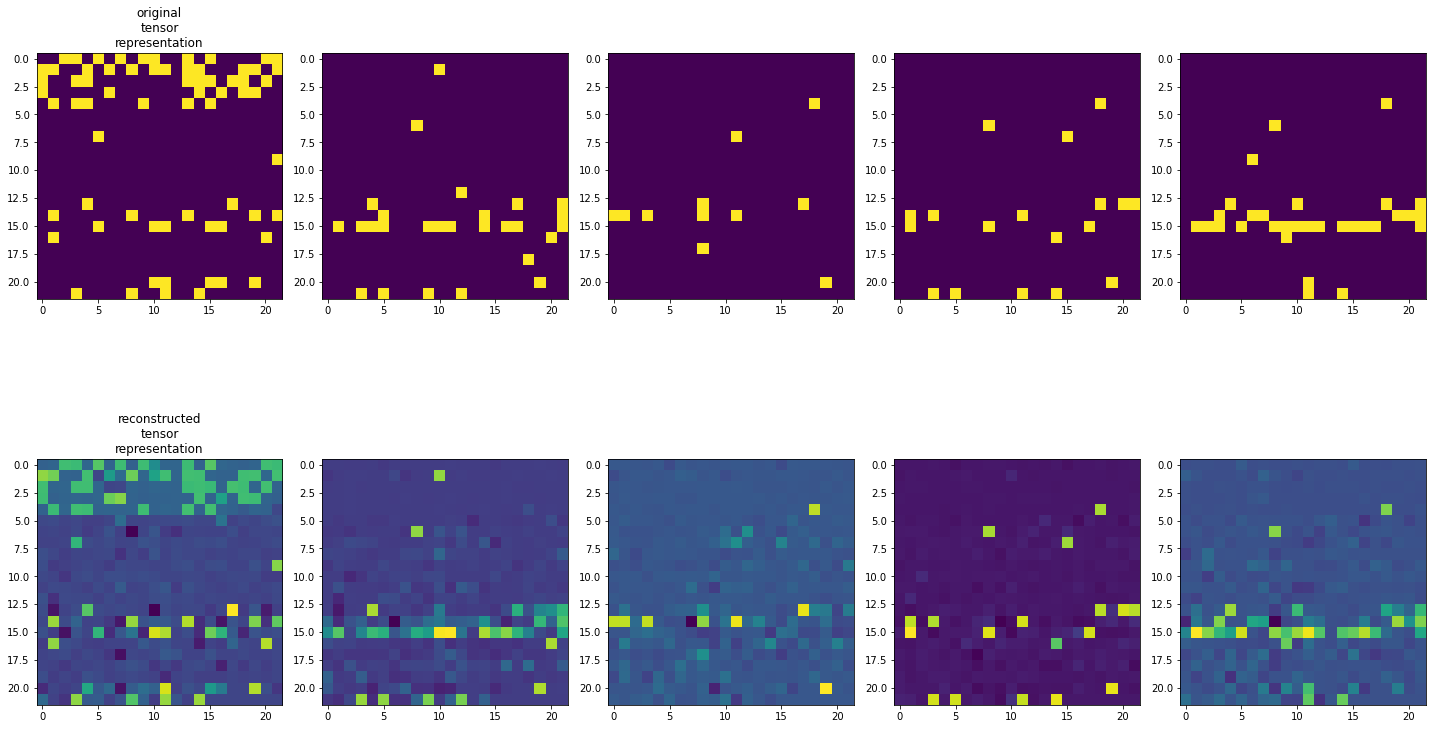

In [8]:
features, reconstructions = get_random_reconstructions(trained_service_autoencoder_model, service_autoencoder_valid_ds, device=device)
plot_reconstructions(features, reconstructions)

### Save Service Autoencoder model

In [9]:
save_module(trained_service_autoencoder_model, name=SERVICES_AUTOENCODER)

### Load User Autoencoder datasets

In [10]:
user_autoencoder_train_ds = load_last_dataset(get_autoencoder_dataset_name(USERS, TRAIN))
user_autoencoder_valid_ds = load_last_dataset(get_autoencoder_dataset_name(USERS, VALID))
user_autoencoder_test_ds = load_last_dataset(get_autoencoder_dataset_name(USERS, TEST))

USER_AE_BATCH_SIZE = 128

user_autoencoder_train_ds_dl = DataLoader(user_autoencoder_train_ds, batch_size=USER_AE_BATCH_SIZE, shuffle=True)
user_autoencoder_valid_ds_dl = DataLoader(user_autoencoder_valid_ds, batch_size=USER_AE_BATCH_SIZE, shuffle=True)
user_autoencoder_test_ds_dl = DataLoader(user_autoencoder_test_ds, batch_size=USER_AE_BATCH_SIZE, shuffle=True)

### Create and train User  Autoencoder

In [11]:
USER_FEATURES_DIM = len(User.objects[0].tensor)
USER_EMBEDDING_DIM = 32

user_autoencoder_model = create_autoencoder_model(
    USERS,
    features_dim=USER_FEATURES_DIM,
    embedding_dim=USER_EMBEDDING_DIM,
    writer=writer,
    train_ds_dl=user_autoencoder_train_ds_dl,
    device=device
)

LR = 0.01
optimizer = Adam(user_autoencoder_model.parameters(), lr=LR)

EPOCHS = 2000

trained_user_autoencoder_model = train_autoencoder(
    model=user_autoencoder_model,
    optimizer=optimizer,
    loss_function=autoencoder_loss_function,
    epochs=EPOCHS,
    train_ds_dl=user_autoencoder_train_ds_dl,
    valid_ds_dl=user_autoencoder_valid_ds_dl,
    writer=writer,
    save_period=10,
    verbose=False,
    device=device)

### Visualize User Autoencoder reconstructions

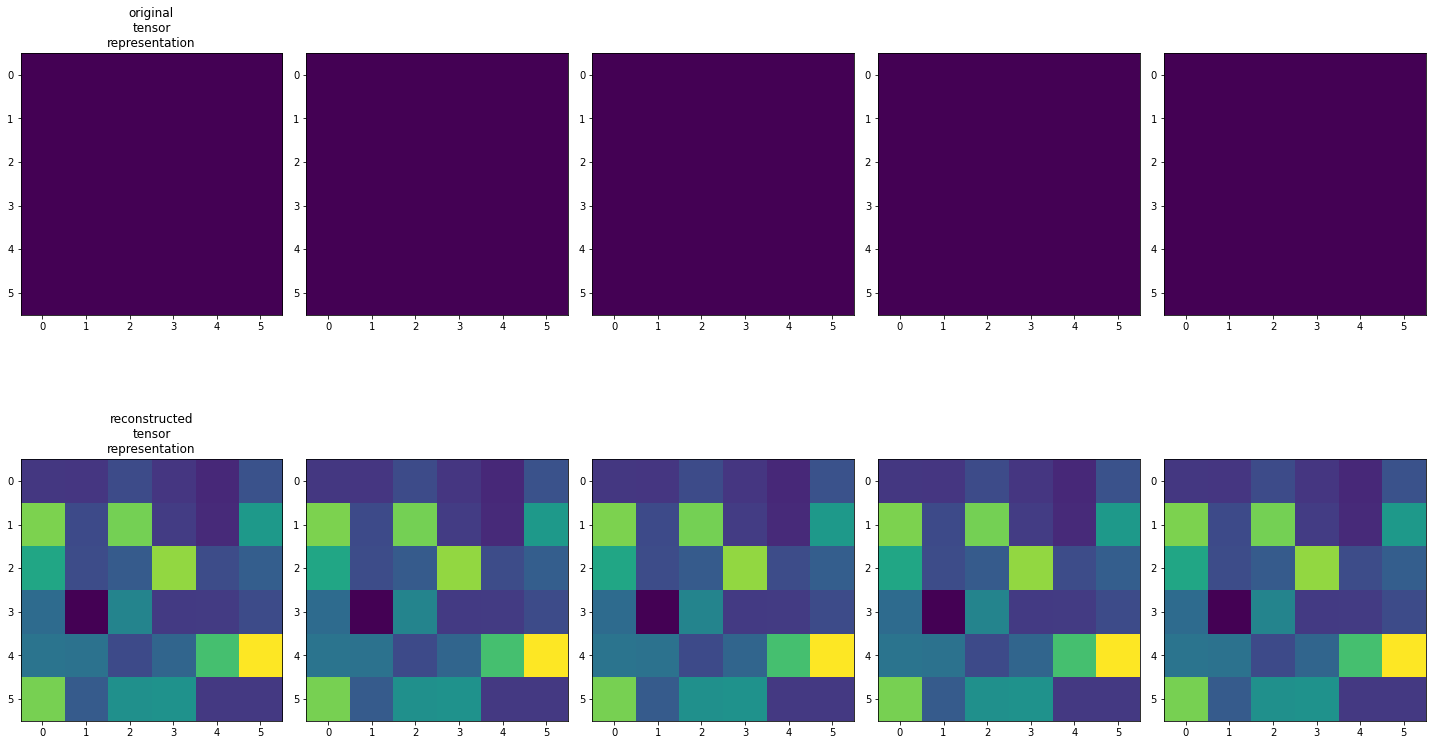

In [12]:
features, reconstructions = get_random_reconstructions(trained_user_autoencoder_model, user_autoencoder_valid_ds, device=device)
plot_reconstructions(features, reconstructions)

### Save User Autoencoder model

In [13]:
save_module(trained_user_autoencoder_model, name=USERS_AUTOENCODER)

# NCF

### Users orders number histogram

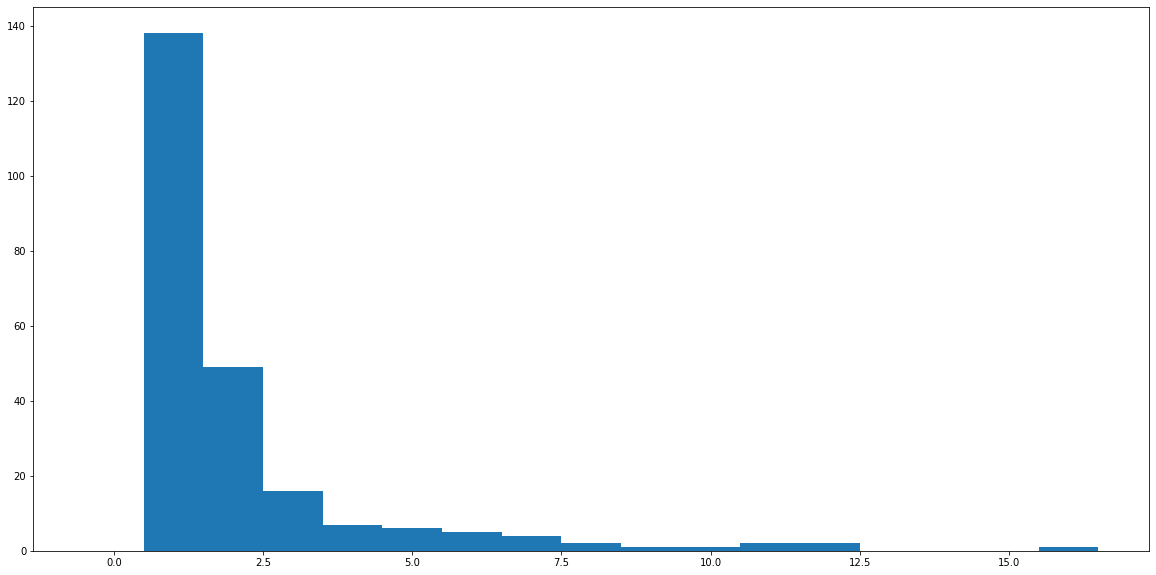

In [14]:
orderings = [len(user.accessed_services) for user in User.objects]
y = list(filter(lambda x: x>0, orderings))
fig =plt.figure(figsize=(20, 10))
plt.hist(y, np.arange(max(y)+1)-0.5)
None

### Load NCF Autoencoder datasets

In [15]:
ncf_train_ds = load_last_dataset(f"{NEURAL_CF} {TRAIN} dataset")
ncf_valid_ds = load_last_dataset(f"{NEURAL_CF} {VALID} dataset")
ncf_test_ds = load_last_dataset(f"{NEURAL_CF} {TEST} dataset")

print(f"train_ds size: {len(ncf_train_ds)}")
print(f"valid_ds size: {len(ncf_valid_ds)}")
print(f"test_ds size: {len(ncf_test_ds)}")

BATCH_SIZE = 32

ncf_train_ds_dl = DataLoader(ncf_train_ds, batch_size=BATCH_SIZE, shuffle=True)
ncf_valid_ds_dl = DataLoader(ncf_valid_ds, batch_size=BATCH_SIZE, shuffle=True)
ncf_test_ds_dl = DataLoader(ncf_test_ds, batch_size=BATCH_SIZE, shuffle=True)

train_ds size: 840
valid_ds size: 134
test_ds size: 54


### Create User and Service Embedders from Autoencoders

In [16]:
service_embedder = create_embedder(trained_service_autoencoder_model)

In [17]:
user_embedder = create_embedder(trained_user_autoencoder_model)

### Set some training constants

In [18]:
USERS_MAX_ID = User.objects.order_by("-id").first().id
SERVICES_MAX_ID = Service.objects.order_by("-id").first().id

MF_EMBEDDING_DIM = 64
USER_IDS_EMBEDDING_DIM = 64
SERVICE_IDS_EMBEDDING_DIM = 64

MLP_LAYERS_SPEC = [64, 32, 16, 8]
CONTENT_MLP_LAYERS_SPEC = [128, 64, 32]

### Neural Collaborative Filtering Model Schema

In [19]:
ncf_architecture_image_path = "./recommender/engine/pre_agent/models/neural_cf_architecture.png"
Image(url=ncf_architecture_image_path, width=800)

### Create and train NCF model

In [20]:
ncf_model = create_nfc_model(
    users_max_id=USERS_MAX_ID,
    services_max_id=SERVICES_MAX_ID,
    mf_embedding_dim=MF_EMBEDDING_DIM,
    user_ids_embedding_dim=USER_IDS_EMBEDDING_DIM,
    service_ids_embedding_dim=SERVICE_IDS_EMBEDDING_DIM,
    user_embedder=user_embedder,
    service_embedder=service_embedder,
    mlp_layers_spec=MLP_LAYERS_SPEC,
    content_mlp_layers_spec=CONTENT_MLP_LAYERS_SPEC,
    writer=writer,
    train_ds_dl=ncf_train_ds_dl,
    device=device
)

ncf_loss_function = torch.nn.BCELoss()

LR = 0.01
ncf_optimizer = Adam(ncf_model.parameters(), lr=LR)

EPOCHS = 500

trained_ncf_model = train_ncf(
    model=ncf_model,
    optimizer=ncf_optimizer,
    loss_function=ncf_loss_function,
    epochs=EPOCHS,
    train_ds_dl=ncf_train_ds_dl,
    valid_ds_dl=ncf_valid_ds_dl,
    save_period=10,
    writer=writer,
    verbose=False,
    device=device
)

### Model Evaluation

In [21]:
loss, acc = evaluate_ncf(trained_ncf_model, ncf_test_ds_dl, ncf_loss_function, accuracy_function, device)
print(f"Testing loss: {loss}, testing accuracy: {acc}")

Testing loss: 1.1634321212768555, testing accuracy: 0.7272727272727273


### Classification report

In [22]:
labels, preds = get_preds_for_ds(trained_ncf_model, ncf_test_ds)
print(classification_report(labels, preds > 0.5))

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.76        27
         1.0       0.77      0.74      0.75        27

    accuracy                           0.76        54
   macro avg       0.76      0.76      0.76        54
weighted avg       0.76      0.76      0.76        54



### Precision Recall Curve

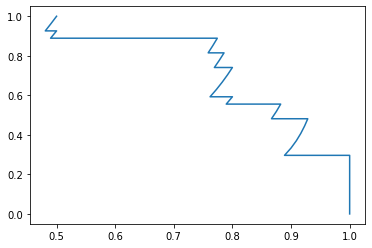

In [23]:
precision, recall, thresholds = precision_recall_curve(labels, preds)
plt.plot(precision, recall)

### ROC Curve

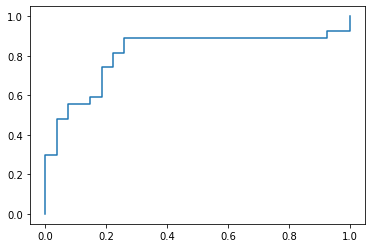

In [24]:
fpr, tpr, thresholds = roc_curve(labels, preds)
x = plt.plot(fpr, tpr)

### NCF Model saving

Transformers are save automatically after creation and fitting inside raw_dataset_to_tensors function so only model should be saved manually.

In [25]:
save_module(trained_ncf_model, name=NEURAL_CF)

### Inferention test

Model loading:

In [26]:
loaded_ncf_model = load_last_module(NEURAL_CF)

Inferention data preparing

In [27]:
user = User.objects[0]
services = list(Service.objects)
service = services[0]

In [28]:
%%time
users_ids, users_tensor, services_ids, services_tensor = user_and_service_to_tensors(user, service)

CPU times: user 1.63 ms, sys: 81 µs, total: 1.71 ms
Wall time: 1.67 ms


In [29]:
%%time
prediction = loaded_ncf_model(users_ids, users_tensor, services_ids, services_tensor).item()

CPU times: user 1.78 ms, sys: 87 µs, total: 1.86 ms
Wall time: 1.65 ms


In [30]:
print(f"Inferenced probability: {prediction}")

Inferenced probability: 0.011953976936638355


In [31]:
%%time
users_ids, users_tensor, services_ids, services_tensor = user_and_services_to_tensors(user, services)

CPU times: user 247 ms, sys: 0 ns, total: 247 ms
Wall time: 246 ms


In [32]:
%time
predictions = loaded_ncf_model(users_ids, users_tensor, services_ids, services_tensor)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


In [33]:
print(f"Inferenced probabilities: {predictions}")

Inferenced probabilities: tensor([[1.1954e-02],
        [2.2071e-01],
        [9.9882e-01],
        [7.6400e-03],
        [1.2707e-02],
        [7.6607e-05],
        [1.9134e-01],
        [4.9203e-01],
        [4.7839e-05],
        [1.8156e-04],
        [1.1601e-01],
        [3.1915e-02],
        [7.1820e-01],
        [4.1285e-04],
        [1.0498e-04],
        [2.8035e-01],
        [6.6242e-01],
        [2.1551e-05],
        [2.3359e-05],
        [7.8448e-02],
        [3.6766e-04],
        [1.7133e-02],
        [2.1821e-02],
        [5.3534e-03],
        [2.3267e-01],
        [3.6103e-04],
        [5.4788e-02],
        [9.9588e-01],
        [7.0121e-03],
        [8.5977e-01],
        [5.1413e-04],
        [5.1531e-03],
        [5.0935e-03],
        [9.0383e-04],
        [8.2331e-01],
        [1.0631e-02],
        [6.0791e-01],
        [8.1915e-02],
        [5.1437e-01],
        [2.8590e-01],
        [1.7564e-03],
        [1.5433e-02],
        [1.2838e-01],
        [9.4030e-01],
      